In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'SR/SwinIR\ -\ Tries'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/SR/SwinIR - Tries


In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.4 MB/s eta 0:00:00


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join
from scipy.io import loadmat
from tqdm import tqdm

In [ ]:
########### Parameters ############


BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0
scale_factor = 4
nb_epochs = 500
cuda = True
CROP_SIZE = 64

device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
########## Datasets ############


class DatasetFromTensor(Dataset):
    def __init__(self, data, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromTensor, self).__init__()
        self.data = data

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.Resize(crop_size, interpolation=Image.BICUBIC)  # bicubic upsampling to get back the original size 
                                        ])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor)  # subsampling the image (half size)
                                        ])
                
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size) # since it's the target, we keep its original quality
                                        ])

    def __getitem__(self, index):
        input = self.data[index]
        target = input.clone()

        GB = transforms.GaussianBlur(kernel_size=(3,3), sigma=(1,1))
        
        input = GB(input)
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.data)


In [ ]:
########## Model #############


class Mlp(nn.Module):  #MLP
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):  #MSA
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):  #STL
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):    #STLs (series of STL inside RSTB)
  """ A basic Swin Transformer layer for one stage.

  Args:
      dim (int): Number of input channels.
      input_resolution (tuple[int]): Input resolution.
      depth (int): Number of blocks.
      num_heads (int): Number of attention heads.
      window_size (int): Local window size.
      mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
      qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
      qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
      drop (float, optional): Dropout rate. Default: 0.0
      attn_drop (float, optional): Attention dropout rate. Default: 0.0
      drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
      norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
      downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
      use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
  """

  def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

      super().__init__()
      self.dim = dim
      self.input_resolution = input_resolution
      self.depth = depth
      self.use_checkpoint = use_checkpoint

      # build blocks
      self.blocks = nn.ModuleList([
          SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                num_heads=num_heads, window_size=window_size,
                                shift_size=0 if (i % 2 == 0) else window_size // 2,
                                mlp_ratio=mlp_ratio,
                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                drop=drop, attn_drop=attn_drop,
                                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                norm_layer=norm_layer)
          for i in range(depth)])

      # patch merging layer
      if downsample is not None:
          self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
      else:
          self.downsample = None

  def forward(self, x, x_size):
      for blk in self.blocks:
          if self.use_checkpoint:
              x = checkpoint.checkpoint(blk, x, x_size)
          else:
              x = blk(x, x_size)
      if self.downsample is not None:
          x = self.downsample(x)
      return x

  def extra_repr(self) -> str:
      return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

  def flops(self):
      flops = 0
      for blk in self.blocks:
          flops += blk.flops()
      if self.downsample is not None:
          flops += self.downsample.flops()
      return flops


class RSTB(nn.Module):  #RSTB
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):    #inside HQ Image Reconstruction
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):   #inside HQ Image reconstruction
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)                                              #Shallow Feature Extraction
            x = self.conv_after_body(self.forward_features(x)) + x              #Deep Feature Extraction + x
            x = self.conv_before_upsample(x)                                    #HQ Image Reconstruction
            x = self.conv_last(self.upsample(x))                                #HQ Image Reconstruction
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops




In [ ]:
########## Load Data #########

data = loadmat('data_Ve5.mat')
w = torch.from_numpy(data['w'])[:256]
w = w.reshape(shape=(w.shape[0], 1, w.shape[1], w.shape[2]))

trainset = DatasetFromTensor(w[:200], scale_factor=scale_factor, with_bicubic_upsampling=False)
testset = DatasetFromTensor(w[200:], scale_factor=scale_factor, with_bicubic_upsampling=False)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
model = SwinIR(upscale=scale_factor, in_chans=1, img_size=CROP_SIZE, window_size=8, img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffle', resi_conv='1conv').to(device)
model = model.float()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []

best_loss_test = float('inf')
best_model = model


for epoch in range(nb_epochs):

    # Train
    avg_psnr = 0
    epoch_loss = 0
    for iteration, batch in enumerate(tqdm(trainloader)):
      input, target = batch[0].to(device), batch[1].to(device)
      input, target = input.float(), target.float()
      optimizer.zero_grad()

      out = model(input)
      loss = criterion(out, target)
      psnr = 10 * log10(1 / loss.item())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      avg_psnr += psnr

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    # Test
    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)
            input, target = input.float(), target.float()

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            epoch_loss += loss.item()
            avg_psnr += psnr

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

    if hist_loss_test[-1] < best_loss_test:
      best_loss_test = hist_loss_test[-1]
      best_model = model

      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model_SwinIR.pt")

model = best_model


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Epoch 0. Training loss: 0.021502957306802274
Average PSNR: 23.97372483078868 dB.


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Epoch 1. Training loss: 0.0037457477021962406
Average PSNR: 28.51578570510711 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 2. Training loss: 0.001346404601354152
Average PSNR: 31.306285649846775 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 3. Training loss: 0.0008793303871061653
Average PSNR: 30.427653466377564 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 4. Training loss: 0.0008211236883653328
Average PSNR: 32.70351565692687 dB.


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Epoch 5. Training loss: 0.0004821381252259016
Average PSNR: 33.74965337250682 dB.


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Epoch 6. Training loss: 0.00083642924844753
Average PSNR: 33.52017415225382 dB.


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Epoch 7. Training loss: 0.0004895094106905163
Average PSNR: 34.31313109748359 dB.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Epoch 8. Training loss: 0.0003471442556474358
Average PSNR: 36.741582580283186 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 9. Training loss: 0.0005281958795967512
Average PSNR: 33.660399590247245 dB.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Epoch 10. Training loss: 0.0005752052291063592
Average PSNR: 37.500749055964164 dB.


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch 11. Training loss: 0.00020321625896031038
Average PSNR: 38.02007381308997 dB.


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Epoch 12. Training loss: 0.00018556345035904088
Average PSNR: 36.80786658698662 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 13. Training loss: 0.00029547629776061513
Average PSNR: 34.78493985379793 dB.


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Epoch 14. Training loss: 0.00021086652734084055
Average PSNR: 36.22607502337536 dB.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Epoch 15. Training loss: 0.00026816602519829757
Average PSNR: 34.391166116827414 dB.


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


Epoch 16. Training loss: 0.0007979607611196116
Average PSNR: 34.49778360895171 dB.


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Epoch 17. Training loss: 0.0002916844615538139
Average PSNR: 40.13037004486009 dB.


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Epoch 18. Training loss: 0.00020925515098497272
Average PSNR: 40.155846401977236 dB.


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


Epoch 19. Training loss: 9.702526018372737e-05
Average PSNR: 40.835002074024196 dB.


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Epoch 20. Training loss: 8.64404554158682e-05
Average PSNR: 41.45595893238918 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 21. Training loss: 8.169101623934693e-05
Average PSNR: 41.970311511760784 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 22. Training loss: 0.00013792565077892506
Average PSNR: 32.20453854196226 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 23. Training loss: 0.0005781402892898768
Average PSNR: 32.87690376120664 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 24. Training loss: 0.0011770551337394863
Average PSNR: 33.03587179184785 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 25. Training loss: 0.0003477558513986878
Average PSNR: 37.82016402754359 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 26. Training loss: 0.00012555477354908362
Average PSNR: 42.18754236156376 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 27. Training loss: 7.580955185403582e-05
Average PSNR: 42.694356448802736 dB.


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Epoch 28. Training loss: 6.379111895512324e-05
Average PSNR: 42.214955217472145 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 29. Training loss: 6.746226456016301e-05
Average PSNR: 40.423166218737734 dB.


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


Epoch 30. Training loss: 7.75521017931169e-05
Average PSNR: 42.54214987137734 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 31. Training loss: 8.183635603927542e-05
Average PSNR: 39.61853330096223 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 32. Training loss: 7.30818671581801e-05
Average PSNR: 40.33702911887081 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 33. Training loss: 7.950013990921434e-05
Average PSNR: 43.76290876882093 dB.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Epoch 34. Training loss: 5.0345967792964075e-05
Average PSNR: 43.7040451004235 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 35. Training loss: 5.379780988732819e-05
Average PSNR: 42.291654503275154 dB.


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


Epoch 36. Training loss: 0.00019749042025068775
Average PSNR: 36.449233752100135 dB.


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Epoch 37. Training loss: 0.00010012054546677973
Average PSNR: 42.29096519492807 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 38. Training loss: 0.00012499124135501916
Average PSNR: 35.16355317852694 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 39. Training loss: 0.0003289851514273323
Average PSNR: 34.9267618070252 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 40. Training loss: 0.00015805290524440352
Average PSNR: 37.698629008087224 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 41. Training loss: 0.00023444098304025828
Average PSNR: 37.26226790211133 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 42. Training loss: 6.960529670323012e-05
Average PSNR: 44.66381183467941 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 43. Training loss: 7.038355237455107e-05
Average PSNR: 44.01638978707586 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 44. Training loss: 6.847366748843342e-05
Average PSNR: 44.95530032891112 dB.


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


Epoch 45. Training loss: 5.170687069039559e-05
Average PSNR: 42.966396814868574 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 46. Training loss: 4.5889681168773676e-05
Average PSNR: 45.6424145626395 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 47. Training loss: 3.4219746776216195e-05
Average PSNR: 43.83341751278027 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 48. Training loss: 3.666561180580175e-05
Average PSNR: 41.50777988655265 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 49. Training loss: 4.111822650884278e-05
Average PSNR: 45.74331392679993 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 50. Training loss: 3.1966435162757986e-05
Average PSNR: 45.465149975439985 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 51. Training loss: 0.0001224475959679694
Average PSNR: 37.399993479134665 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 52. Training loss: 0.00018902465526480228
Average PSNR: 41.46419606164149 dB.


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 53. Training loss: 0.0005805449964827858
Average PSNR: 32.510442876710826 dB.


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch 54. Training loss: 0.00029397990088909866
Average PSNR: 39.57927665751238 dB.


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Epoch 55. Training loss: 0.00016181272469111718
Average PSNR: 43.84633541778247 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 56. Training loss: 3.401001362362876e-05
Average PSNR: 43.523993262643394 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 57. Training loss: 2.9331751466088463e-05
Average PSNR: 44.40947651904274 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 58. Training loss: 3.369112608197611e-05
Average PSNR: 46.09494298975976 dB.


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Epoch 59. Training loss: 2.8391658579494104e-05
Average PSNR: 45.59444163267663 dB.


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


Epoch 60. Training loss: 2.4921476542658637e-05
Average PSNR: 45.464857424445576 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 61. Training loss: 2.808594133966835e-05
Average PSNR: 43.86493224789509 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 62. Training loss: 0.0005079059057607083
Average PSNR: 36.95345123838393 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 63. Training loss: 0.0002061774579487974
Average PSNR: 40.13978841687039 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 64. Training loss: 0.00014557047295966186
Average PSNR: 43.60088125115593 dB.


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Epoch 65. Training loss: 2.635034717968665e-05
Average PSNR: 46.680750404255114 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 66. Training loss: 2.1296599115885328e-05
Average PSNR: 46.77725802761584 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 67. Training loss: 2.300389671290759e-05
Average PSNR: 47.2670427647468 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 68. Training loss: 1.893331032988499e-05
Average PSNR: 45.310904345559244 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 69. Training loss: 5.01200141661684e-05
Average PSNR: 43.91896212231886 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 70. Training loss: 4.214260345179355e-05
Average PSNR: 43.98481551859298 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 71. Training loss: 2.4344979883608176e-05
Average PSNR: 48.06904809812454 dB.


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Epoch 72. Training loss: 1.6835565238579873e-05
Average PSNR: 47.66502918161024 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 73. Training loss: 1.6991567536024375e-05
Average PSNR: 47.82686169677631 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 74. Training loss: 2.105787592881825e-05
Average PSNR: 45.86572419749279 dB.


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


Epoch 75. Training loss: 2.6057007362396688e-05
Average PSNR: 45.336972650022126 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 76. Training loss: 3.3964147078222596e-05
Average PSNR: 41.7641689665308 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 77. Training loss: 3.086330609221477e-05
Average PSNR: 46.60538360890699 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 78. Training loss: 1.7045322001649764e-05
Average PSNR: 46.833419216929265 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 79. Training loss: 2.943492470876663e-05
Average PSNR: 45.084950113731146 dB.


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 80. Training loss: 2.591646603832487e-05
Average PSNR: 47.453532457725125 dB.


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch 81. Training loss: 1.8634470161487116e-05
Average PSNR: 48.30284392524556 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 82. Training loss: 1.6766277276474284e-05
Average PSNR: 46.967562029615294 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 83. Training loss: 2.6803115724760572e-05
Average PSNR: 41.948310140901704 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 84. Training loss: 4.016787448563264e-05
Average PSNR: 47.16679403933843 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 85. Training loss: 1.9507933902787045e-05
Average PSNR: 49.356128515126734 dB.


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Epoch 86. Training loss: 1.4780148212594213e-05
Average PSNR: 49.16642820283393 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 87. Training loss: 1.2759900746459607e-05
Average PSNR: 47.66378554543848 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 88. Training loss: 7.366517311311327e-05
Average PSNR: 40.568827755289014 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 89. Training loss: 0.00023368804577330592
Average PSNR: 38.06146880125284 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 90. Training loss: 6.77041761991859e-05
Average PSNR: 44.72981004984687 dB.


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Epoch 91. Training loss: 6.125933563453146e-05
Average PSNR: 37.344309082381244 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 92. Training loss: 0.00010303044549800689
Average PSNR: 45.52713716111759 dB.


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


Epoch 93. Training loss: 4.7470332046941623e-05
Average PSNR: 42.287463678753305 dB.


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch 94. Training loss: 0.00010249531449517235
Average PSNR: 38.358980215342335 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 95. Training loss: 9.129823971306905e-05
Average PSNR: 42.42312292659619 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 96. Training loss: 5.832888535223901e-05
Average PSNR: 42.450904134352 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 97. Training loss: 4.749849184008781e-05
Average PSNR: 45.57163431867088 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 98. Training loss: 2.170350169762969e-05
Average PSNR: 45.844528223313 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 99. Training loss: 2.5793606146180536e-05
Average PSNR: 46.453783276820296 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 100. Training loss: 1.6782193479230046e-05
Average PSNR: 47.7370277366032 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 101. Training loss: 1.4858699323667679e-05
Average PSNR: 48.32098406348882 dB.


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Epoch 102. Training loss: 3.575297007046174e-05
Average PSNR: 46.521818656432934 dB.


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch 103. Training loss: 1.33353166620509e-05
Average PSNR: 48.221503747051756 dB.


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Epoch 104. Training loss: 1.3126002504577628e-05
Average PSNR: 48.87804445770489 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 105. Training loss: 0.0001209641998684674
Average PSNR: 41.00338422026862 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 106. Training loss: 0.0001430133568646852
Average PSNR: 31.163396371314594 dB.


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


Epoch 107. Training loss: 0.0004787080705864355
Average PSNR: 26.617851396713768 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 108. Training loss: 0.0004938891697383952
Average PSNR: 42.31707725284606 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 109. Training loss: 2.821272373694228e-05
Average PSNR: 48.831493590643056 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 110. Training loss: 1.535940029498306e-05
Average PSNR: 48.28181418190555 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 111. Training loss: 1.813988727008109e-05
Average PSNR: 46.70489139433708 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 112. Training loss: 1.5341131256718654e-05
Average PSNR: 48.71743815725912 dB.


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 113. Training loss: 1.5883457863310468e-05
Average PSNR: 48.552658328601076 dB.


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch 114. Training loss: 1.2302946261115722e-05
Average PSNR: 50.24231870028172 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 115. Training loss: 9.124720509134932e-06
Average PSNR: 50.13237770332025 dB.


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch 116. Training loss: 1.700435846032633e-05
Average PSNR: 47.99674801896988 dB.


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 117. Training loss: 1.6130622061609756e-05
Average PSNR: 44.26474262788467 dB.


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Epoch 118. Training loss: 1.537551746878307e-05
Average PSNR: 48.93103261204703 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 119. Training loss: 9.7076873316837e-06
Average PSNR: 50.43483154615221 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 120. Training loss: 9.658950784796615e-06
Average PSNR: 49.97308749776391 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 121. Training loss: 1.6488507999383728e-05
Average PSNR: 46.41565276974576 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 122. Training loss: 2.491889636075939e-05
Average PSNR: 50.09759355196478 dB.


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


Epoch 123. Training loss: 1.539602189041034e-05
Average PSNR: 45.592336188901676 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 124. Training loss: 2.6525041666900505e-05
Average PSNR: 45.52004042041455 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 125. Training loss: 2.5852237595245242e-05
Average PSNR: 44.01425422918573 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 126. Training loss: 3.2339932331524324e-05
Average PSNR: 48.71354419832686 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 127. Training loss: 2.5837888351816218e-05
Average PSNR: 39.33242608026291 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 128. Training loss: 3.354586924615432e-05
Average PSNR: 50.392256939755136 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 129. Training loss: 1.005274989438476e-05
Average PSNR: 48.93762954509248 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 130. Training loss: 8.35448063298827e-06
Average PSNR: 50.211692949249745 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 131. Training loss: 7.524311467932421e-06
Average PSNR: 50.33848630615971 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 132. Training loss: 7.333666362683289e-06
Average PSNR: 50.083899089359626 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 133. Training loss: 6.627081070291752e-06
Average PSNR: 50.557281718915924 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 134. Training loss: 7.362341002590256e-06
Average PSNR: 51.49036509577724 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 135. Training loss: 1.4905147036188282e-05
Average PSNR: 50.54765670761723 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 136. Training loss: 1.2701017203653464e-05
Average PSNR: 44.50472686056319 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 137. Training loss: 2.8973404077987652e-05
Average PSNR: 48.06245197282994 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 138. Training loss: 3.520269163345802e-05
Average PSNR: 42.30188698435405 dB.


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


Epoch 139. Training loss: 5.2979118372604716e-05
Average PSNR: 44.23866051474245 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 140. Training loss: 7.800326671713265e-05
Average PSNR: 44.14724408745176 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 141. Training loss: 0.00019747038844798227
Average PSNR: 34.99919754216358 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 142. Training loss: 0.00010020470597737585
Average PSNR: 44.36426456101681 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 143. Training loss: 2.6178738535236336e-05
Average PSNR: 47.77964229745113 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 144. Training loss: 4.019930296635721e-05
Average PSNR: 38.36807668618684 dB.


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


Epoch 145. Training loss: 6.701608723233221e-05
Average PSNR: 45.94605970430257 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 146. Training loss: 2.8923877471243033e-05
Average PSNR: 45.1993577192855 dB.


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Epoch 147. Training loss: 1.6607900834060272e-05
Average PSNR: 48.954679892010276 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 148. Training loss: 8.398406380365487e-06
Average PSNR: 51.80232883065905 dB.


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


Epoch 149. Training loss: 6.925540756128612e-06
Average PSNR: 51.26888342717465 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 150. Training loss: 1.8372982367509394e-05
Average PSNR: 47.88609081315739 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 151. Training loss: 1.5627359325662837e-05
Average PSNR: 50.200686509686 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 152. Training loss: 8.57209210334986e-05
Average PSNR: 33.44003349025926 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 153. Training loss: 0.00024735620543651747
Average PSNR: 39.85764270119635 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 154. Training loss: 4.709975553851109e-05
Average PSNR: 49.35846758373178 dB.


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch 155. Training loss: 9.107963687711163e-06
Average PSNR: 51.10799017399427 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 156. Training loss: 7.93234621596639e-06
Average PSNR: 51.027256960822335 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 157. Training loss: 1.0026072436630784e-05
Average PSNR: 48.893103144248904 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 158. Training loss: 7.227490941659198e-06
Average PSNR: 52.95346156309454 dB.


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Epoch 159. Training loss: 5.222250615588564e-06
Average PSNR: 53.241159998613576 dB.


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Epoch 160. Training loss: 9.913342787513101e-06
Average PSNR: 51.550478927986305 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 161. Training loss: 1.6439742330476294e-05
Average PSNR: 50.401295924005275 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 162. Training loss: 2.8756735255228704e-05
Average PSNR: 43.65124247702958 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 163. Training loss: 0.00010585997373709689
Average PSNR: 39.98303820096051 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 164. Training loss: 0.00041092318191658704
Average PSNR: 35.942530785487534 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 165. Training loss: 0.00022161957236676243
Average PSNR: 45.245020368518546 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 166. Training loss: 2.830073641234776e-05
Average PSNR: 48.99645600889398 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 167. Training loss: 1.1534112645676942e-05
Average PSNR: 51.660509438298796 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 168. Training loss: 8.257598437921843e-06
Average PSNR: 50.468849146497085 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 169. Training loss: 5.540385718632023e-06
Average PSNR: 52.9567102641487 dB.


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Epoch 170. Training loss: 5.283765517560823e-06
Average PSNR: 53.30686109532987 dB.


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Epoch 171. Training loss: 5.1691554108401765e-06
Average PSNR: 48.99821317174765 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 172. Training loss: 6.690834075016028e-06
Average PSNR: 52.04203118646597 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 173. Training loss: 5.315713597155991e-06
Average PSNR: 53.202485078351906 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 174. Training loss: 5.923558746872004e-06
Average PSNR: 47.059331488819474 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 175. Training loss: 6.542589594573656e-06
Average PSNR: 53.1058230374693 dB.


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Epoch 176. Training loss: 4.189064920865348e-06
Average PSNR: 51.196746436889995 dB.


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Epoch 177. Training loss: 4.649354682442208e-06
Average PSNR: 53.15307735773087 dB.


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


Epoch 178. Training loss: 4.699542541857227e-06
Average PSNR: 54.20852944009316 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 179. Training loss: 7.104788819560781e-06
Average PSNR: 50.27853644577248 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 180. Training loss: 7.939604274724844e-06
Average PSNR: 51.654302947218234 dB.


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Epoch 181. Training loss: 4.592561726894928e-06
Average PSNR: 52.83430914278459 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 182. Training loss: 7.272037319125957e-06
Average PSNR: 46.87730241095268 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 183. Training loss: 1.1136937996525375e-05
Average PSNR: 52.49962606833544 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 184. Training loss: 6.399903722922317e-06
Average PSNR: 52.708874081223314 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 185. Training loss: 3.9666072407271716e-05
Average PSNR: 37.85639575689201 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 186. Training loss: 3.718668922374491e-05
Average PSNR: 39.24360302601252 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 187. Training loss: 3.308076766188606e-05
Average PSNR: 47.71650098120064 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 188. Training loss: 9.368205146529363e-06
Average PSNR: 51.19047993025753 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 189. Training loss: 1.380466233513289e-05
Average PSNR: 47.218327042418984 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 190. Training loss: 7.719395453023025e-05
Average PSNR: 46.695060686534255 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 191. Training loss: 1.215058367961319e-05
Average PSNR: 50.80265360426366 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 192. Training loss: 1.588245278071554e-05
Average PSNR: 51.455248018120486 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 193. Training loss: 7.610597926941409e-06
Average PSNR: 53.20530361153043 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 194. Training loss: 5.959513255220372e-06
Average PSNR: 53.48125597110665 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 195. Training loss: 6.8485548854368976e-06
Average PSNR: 49.553286215945285 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 196. Training loss: 2.984987352647295e-05
Average PSNR: 37.3626794648339 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 197. Training loss: 5.568850294366712e-05
Average PSNR: 45.87434137339323 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 198. Training loss: 8.302611553517636e-05
Average PSNR: 42.02291590511437 dB.


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 199. Training loss: 2.5761421093193348e-05
Average PSNR: 50.37686770831491 dB.


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Epoch 200. Training loss: 8.144584908222897e-06
Average PSNR: 52.70060500819381 dB.


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


Epoch 201. Training loss: 8.355716945516178e-06
Average PSNR: 52.398089534150806 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 202. Training loss: 4.527498717834533e-06
Average PSNR: 54.46427231999725 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 203. Training loss: 9.013768299155344e-06
Average PSNR: 49.158531735694204 dB.


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


Epoch 204. Training loss: 1.3015422523494635e-05
Average PSNR: 52.004776876555574 dB.


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 205. Training loss: 3.5828101272272764e-05
Average PSNR: 45.14702858354111 dB.


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


Epoch 206. Training loss: 4.55187842817395e-05
Average PSNR: 45.779742873878526 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 207. Training loss: 1.336056065156299e-05
Average PSNR: 51.69666679042102 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 208. Training loss: 2.0659544943555375e-05
Average PSNR: 53.4051581739683 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 209. Training loss: 4.508424199229921e-06
Average PSNR: 53.9495840582763 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 210. Training loss: 5.672958436662156e-06
Average PSNR: 52.48003102044568 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 211. Training loss: 2.7590216650423826e-05
Average PSNR: 48.7700726907835 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 212. Training loss: 5.828964876855025e-05
Average PSNR: 41.38601854511557 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 213. Training loss: 3.382353213964962e-05
Average PSNR: 43.728560066584336 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 214. Training loss: 5.361488612834364e-05
Average PSNR: 45.31118890928858 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 215. Training loss: 4.8309359644918e-05
Average PSNR: 48.87399565412092 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 216. Training loss: 1.206530741910683e-05
Average PSNR: 50.00721541230941 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 217. Training loss: 3.0929619306334644e-05
Average PSNR: 42.01282380186289 dB.


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Epoch 218. Training loss: 2.3783981259839492e-05
Average PSNR: 52.22545237077692 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 219. Training loss: 6.053829415577638e-06
Average PSNR: 53.911526805931416 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 220. Training loss: 3.1653270775677813e-06
Average PSNR: 54.555108292371266 dB.


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Epoch 221. Training loss: 2.8949186025784e-06
Average PSNR: 55.53088065245172 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 222. Training loss: 3.321960195989959e-06
Average PSNR: 55.2799046807721 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 223. Training loss: 3.4742021671263503e-06
Average PSNR: 55.11472358586701 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 224. Training loss: 3.3439277922298063e-06
Average PSNR: 54.56599330111287 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 225. Training loss: 4.614523227246537e-06
Average PSNR: 55.809044665114456 dB.


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch 226. Training loss: 5.8422518668521664e-06
Average PSNR: 50.97227704085343 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 227. Training loss: 1.3872110639567836e-05
Average PSNR: 51.183913609079504 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 228. Training loss: 1.7565119633218275e-05
Average PSNR: 46.257010664675036 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 229. Training loss: 2.5318912503280443e-05
Average PSNR: 47.09459108387262 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 230. Training loss: 1.4066709218241158e-05
Average PSNR: 48.294934995849296 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 231. Training loss: 3.995849158854981e-05
Average PSNR: 46.04604374746821 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 232. Training loss: 0.00014910632104147225
Average PSNR: 29.924627133050453 dB.


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Epoch 233. Training loss: 0.00040961831917229574
Average PSNR: 43.84968935343996 dB.


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


Epoch 234. Training loss: 2.8935678747075143e-05
Average PSNR: 50.504096250577035 dB.


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 235. Training loss: 6.479578887592652e-06
Average PSNR: 52.73285748969924 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 236. Training loss: 4.7440379967156336e-06
Average PSNR: 54.41626795817702 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 237. Training loss: 4.3344515597709684e-06
Average PSNR: 54.75186387234216 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 238. Training loss: 3.224530228180811e-06
Average PSNR: 55.35960037477825 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 239. Training loss: 2.9498640469682867e-06
Average PSNR: 55.71221471690235 dB.


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Epoch 240. Training loss: 2.6995766666004784e-06
Average PSNR: 55.26673297639775 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 241. Training loss: 2.9241471111163264e-06
Average PSNR: 55.89315702034901 dB.


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Epoch 242. Training loss: 2.6067011754093982e-06
Average PSNR: 55.09730746486388 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 243. Training loss: 2.596369793081976e-06
Average PSNR: 54.93637318299714 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 244. Training loss: 2.9931754261269817e-06
Average PSNR: 55.416018746877626 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 245. Training loss: 2.9820563258908805e-06
Average PSNR: 54.95157428450629 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 246. Training loss: 3.297925773040333e-06
Average PSNR: 55.140999292170136 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 247. Training loss: 5.147909478182555e-06
Average PSNR: 55.61944536639843 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 248. Training loss: 4.909973035864823e-06
Average PSNR: 54.8720165861129 dB.


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]


Epoch 249. Training loss: 5.785112634839607e-06
Average PSNR: 52.91570363150296 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 250. Training loss: 3.883678459715156e-06
Average PSNR: 54.26006841422076 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 251. Training loss: 3.1702826208857004e-06
Average PSNR: 53.20248705419577 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 252. Training loss: 4.1710073082867895e-06
Average PSNR: 47.9802163640236 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 253. Training loss: 4.013174333522329e-05
Average PSNR: 45.0788035452565 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 254. Training loss: 4.7223344208759956e-05
Average PSNR: 46.0747254275684 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 255. Training loss: 5.269874503937899e-05
Average PSNR: 45.46541122649355 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 256. Training loss: 0.00015546466296655125
Average PSNR: 34.001597575889186 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 257. Training loss: 0.00017223982151335805
Average PSNR: 46.936059703847725 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 258. Training loss: 1.2925340806759777e-05
Average PSNR: 53.675459678429476 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 259. Training loss: 5.701525597032742e-06
Average PSNR: 48.62260282530633 dB.


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


Epoch 260. Training loss: 1.555676576572296e-05
Average PSNR: 49.18172676740625 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 261. Training loss: 1.0434821269882378e-05
Average PSNR: 54.25919054057946 dB.


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 262. Training loss: 7.059043650770036e-06
Average PSNR: 51.730186790503645 dB.


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


Epoch 263. Training loss: 3.7767880985484227e-06
Average PSNR: 55.81654458873858 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 264. Training loss: 2.7698721555680095e-06
Average PSNR: 55.7663899252238 dB.


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


Epoch 265. Training loss: 2.53309079880637e-06
Average PSNR: 55.41101636826517 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 266. Training loss: 2.1719464302805136e-06
Average PSNR: 56.51904502114131 dB.


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch 267. Training loss: 2.213040208971506e-06
Average PSNR: 56.786722715877104 dB.


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Epoch 268. Training loss: 2.329161241050315e-06
Average PSNR: 56.82896025521114 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 269. Training loss: 2.3036462448544626e-06
Average PSNR: 54.432486979990166 dB.


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Epoch 270. Training loss: 3.843911595140526e-06
Average PSNR: 55.56635776173382 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 271. Training loss: 3.7072472264298996e-06
Average PSNR: 53.07812642248263 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 272. Training loss: 1.192052925034659e-05
Average PSNR: 48.622246747034595 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 273. Training loss: 5.887111124138755e-06
Average PSNR: 54.348458104615005 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 274. Training loss: 3.300101971035474e-06
Average PSNR: 55.55775743392452 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 275. Training loss: 2.472897178904532e-06
Average PSNR: 54.07073351430915 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 276. Training loss: 2.4602186226729827e-06
Average PSNR: 56.49157881440916 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 277. Training loss: 2.414355628843623e-06
Average PSNR: 53.96897865508243 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 278. Training loss: 3.075487829391932e-05
Average PSNR: 43.751626277022446 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 279. Training loss: 6.140117548056879e-05
Average PSNR: 46.939914150114 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 280. Training loss: 1.5922063184916623e-05
Average PSNR: 47.25540595797702 dB.


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Epoch 281. Training loss: 0.00021516041854738433
Average PSNR: 41.492704553004124 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 282. Training loss: 4.3134275874763264e-05
Average PSNR: 48.32859229664832 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 283. Training loss: 1.1474838415779232e-05
Average PSNR: 53.179048282520135 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 284. Training loss: 3.890520119966823e-06
Average PSNR: 55.35914200450167 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 285. Training loss: 3.274590631008323e-06
Average PSNR: 55.767535692820886 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 286. Training loss: 2.563169978202495e-06
Average PSNR: 55.81427861917475 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 287. Training loss: 2.2585703504773845e-06
Average PSNR: 56.81388643972152 dB.


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


Epoch 288. Training loss: 2.1144114521121083e-06
Average PSNR: 57.0356839456987 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 289. Training loss: 2.8734736633850844e-06
Average PSNR: 54.31163329784935 dB.


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


Epoch 290. Training loss: 4.04665588575881e-06
Average PSNR: 52.76433143701323 dB.


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


Epoch 291. Training loss: 2.9831194387952562e-06
Average PSNR: 56.99779742586564 dB.


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 292. Training loss: 2.0979405962862075e-06
Average PSNR: 55.577211193679894 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 293. Training loss: 2.0523538296401966e-06
Average PSNR: 56.66986473912105 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 294. Training loss: 1.9024695711777895e-06
Average PSNR: 57.27318008560074 dB.


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


Epoch 295. Training loss: 1.7944182377505058e-06
Average PSNR: 57.445625857503664 dB.


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Epoch 296. Training loss: 2.2572209218196803e-06
Average PSNR: 56.136596518509805 dB.


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Epoch 297. Training loss: 2.285068653691269e-06
Average PSNR: 56.67384646646068 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 298. Training loss: 2.0744530957017558e-06
Average PSNR: 55.21711576602802 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 299. Training loss: 2.0285353116378247e-06
Average PSNR: 56.01714368085222 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 300. Training loss: 3.199206280442013e-06
Average PSNR: 52.63962079040419 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 301. Training loss: 8.348588489752728e-06
Average PSNR: 47.57097687675766 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 302. Training loss: 8.619492979050847e-05
Average PSNR: 37.509502751316184 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 303. Training loss: 0.0001012469125635107
Average PSNR: 40.80162329703453 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 304. Training loss: 4.3539927210076714e-05
Average PSNR: 49.07473746439548 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 305. Training loss: 1.4192622775226482e-05
Average PSNR: 53.070484351726876 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 306. Training loss: 3.5286392858324687e-06
Average PSNR: 56.246276169244844 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 307. Training loss: 3.349366991187708e-06
Average PSNR: 51.084009317827324 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 308. Training loss: 1.3389130749601464e-05
Average PSNR: 50.13872546960692 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 309. Training loss: 1.1292593185316946e-05
Average PSNR: 51.61146335708309 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 310. Training loss: 1.655009566093213e-05
Average PSNR: 46.6223609218684 dB.


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Epoch 311. Training loss: 2.0736977276101243e-05
Average PSNR: 53.73743057485926 dB.


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Epoch 312. Training loss: 7.301838249986758e-06
Average PSNR: 53.51374035673907 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 313. Training loss: 3.6081597636439257e-06
Average PSNR: 53.98325224949825 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 314. Training loss: 2.9224681406958554e-06
Average PSNR: 57.328962547848086 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 315. Training loss: 2.0324029719631655e-06
Average PSNR: 56.59896795288348 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 316. Training loss: 5.972642322831234e-06
Average PSNR: 53.14498852234994 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 317. Training loss: 6.674244519672357e-05
Average PSNR: 38.70996584390448 dB.


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Epoch 318. Training loss: 0.0007320213622733718
Average PSNR: 38.335462827823015 dB.


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


Epoch 319. Training loss: 8.644435645692283e-05
Average PSNR: 45.546695858769446 dB.


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


Epoch 320. Training loss: 1.932110391862807e-05
Average PSNR: 47.9267472683963 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 321. Training loss: 1.4881783918099246e-05
Average PSNR: 52.43760219484728 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 322. Training loss: 4.198272026769701e-06
Average PSNR: 54.913019250925274 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 323. Training loss: 3.4698293666224343e-06
Average PSNR: 53.84285170962729 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 324. Training loss: 3.0670625028506036e-06
Average PSNR: 54.88442711577877 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 325. Training loss: 2.7243271301813365e-06
Average PSNR: 56.095311805828764 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 326. Training loss: 2.465271459186624e-06
Average PSNR: 56.09231868320319 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 327. Training loss: 2.4790823476905645e-06
Average PSNR: 56.03015219253947 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 328. Training loss: 2.4537921967748846e-06
Average PSNR: 55.03239606762325 dB.


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


Epoch 329. Training loss: 2.647958219768043e-06
Average PSNR: 52.970455373363436 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 330. Training loss: 3.2777259639260592e-06
Average PSNR: 55.969255263799354 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 331. Training loss: 2.212140652773087e-06
Average PSNR: 56.68090895061541 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 332. Training loss: 2.3835601950850104e-06
Average PSNR: 56.127198749906256 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 333. Training loss: 2.583818125003745e-06
Average PSNR: 56.57081488024726 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 334. Training loss: 2.446534060709382e-06
Average PSNR: 57.02196839509626 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 335. Training loss: 2.1242101547613858e-06
Average PSNR: 57.033987880313745 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 336. Training loss: 2.0425311595317906e-06
Average PSNR: 55.060504758226706 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 337. Training loss: 2.1649202449225412e-06
Average PSNR: 57.17024251053145 dB.


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Epoch 338. Training loss: 1.965176923022227e-06
Average PSNR: 57.055382342260295 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 339. Training loss: 1.8932891293843569e-06
Average PSNR: 56.503539625923146 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 340. Training loss: 1.923449387959408e-06
Average PSNR: 56.92284602385154 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 341. Training loss: 1.8267072732669476e-06
Average PSNR: 57.43601641849242 dB.


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch 342. Training loss: 1.9135068851028335e-06
Average PSNR: 57.56207165805892 dB.


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Epoch 343. Training loss: 2.2348324046106426e-06
Average PSNR: 54.23255021896039 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 344. Training loss: 5.743698320657131e-06
Average PSNR: 56.34445340356568 dB.


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Epoch 345. Training loss: 5.0031827117891224e-06
Average PSNR: 51.15359840819998 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 346. Training loss: 6.856262052679085e-06
Average PSNR: 53.96853646168618 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 347. Training loss: 3.832288598459854e-06
Average PSNR: 50.268844098702644 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 348. Training loss: 3.619717288074753e-05
Average PSNR: 46.171722904656136 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 349. Training loss: 2.0395295641719714e-05
Average PSNR: 46.13829072070015 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 350. Training loss: 9.284138241127948e-06
Average PSNR: 47.01822759667759 dB.


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 351. Training loss: 1.6989421819744166e-05
Average PSNR: 52.776415078020236 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 352. Training loss: 3.106706779817614e-05
Average PSNR: 48.83243839137214 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 353. Training loss: 4.563311497804534e-05
Average PSNR: 46.96908025596463 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 354. Training loss: 3.0343626967805903e-05
Average PSNR: 44.11990077749614 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 355. Training loss: 8.31690315681044e-05
Average PSNR: 48.950832859029745 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 356. Training loss: 7.330191042456136e-06
Average PSNR: 55.157754777199834 dB.


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 357. Training loss: 2.529059913740639e-06
Average PSNR: 56.718613060947135 dB.


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Epoch 358. Training loss: 2.1309236558408883e-06
Average PSNR: 56.73753529684341 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 359. Training loss: 2.2558681916962088e-06
Average PSNR: 56.806981089050105 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 360. Training loss: 1.962548292340216e-06
Average PSNR: 56.71482970695107 dB.


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


Epoch 361. Training loss: 2.231563457826269e-06
Average PSNR: 56.9927020184716 dB.


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Epoch 362. Training loss: 2.4575987185926353e-06
Average PSNR: 56.37360327966913 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 363. Training loss: 2.465475597546174e-06
Average PSNR: 57.607185498581465 dB.


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Epoch 364. Training loss: 1.7601282388568507e-06
Average PSNR: 57.68625327601044 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 365. Training loss: 1.6515842662556679e-06
Average PSNR: 58.11499984272224 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 366. Training loss: 3.7573579925265223e-06
Average PSNR: 47.338923491714134 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 367. Training loss: 1.724951898040672e-05
Average PSNR: 46.42421643159823 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 368. Training loss: 4.3218251698817765e-06
Average PSNR: 57.23128222373827 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 369. Training loss: 1.8574023215478519e-06
Average PSNR: 57.219838936379524 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 370. Training loss: 1.671289408022858e-06
Average PSNR: 58.094308130600446 dB.


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch 371. Training loss: 2.1070647949272826e-06
Average PSNR: 55.334079168659464 dB.


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 372. Training loss: 2.694045888347318e-06
Average PSNR: 56.512459437477574 dB.


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Epoch 373. Training loss: 1.9449761657597266e-06
Average PSNR: 55.42071715739478 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 374. Training loss: 1.9894190700142643e-06
Average PSNR: 57.49540798319959 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 375. Training loss: 2.092252632337477e-06
Average PSNR: 57.58635880078248 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 376. Training loss: 2.309257339447868e-06
Average PSNR: 51.16347727581115 dB.


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Epoch 377. Training loss: 9.793128347155289e-06
Average PSNR: 52.86334423199703 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 378. Training loss: 4.3114345999129e-06
Average PSNR: 52.300153973079496 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 379. Training loss: 3.0192236454240628e-06
Average PSNR: 56.07007777828101 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 380. Training loss: 3.6574844102688077e-06
Average PSNR: 53.38528338242632 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 381. Training loss: 3.0986588649284387e-06
Average PSNR: 52.17845189734218 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 382. Training loss: 0.00010085516541039397
Average PSNR: 41.10396403846598 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 383. Training loss: 3.597094566430315e-05
Average PSNR: 46.561735666484026 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 384. Training loss: 1.3692596230612252e-05
Average PSNR: 45.802301713145006 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 385. Training loss: 1.560046258418879e-05
Average PSNR: 50.41193593269595 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 386. Training loss: 4.568257513710705e-05
Average PSNR: 43.72934375321239 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 387. Training loss: 1.6282207138829107e-05
Average PSNR: 54.92043548997021 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 388. Training loss: 2.598780199605244e-06
Average PSNR: 56.95719936365435 dB.


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


Epoch 389. Training loss: 2.232125445971178e-06
Average PSNR: 56.7165957063292 dB.


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Epoch 390. Training loss: 1.8590298805065686e-06
Average PSNR: 55.98736772547475 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 391. Training loss: 2.70649670255807e-06
Average PSNR: 54.242402881770666 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 392. Training loss: 1.0755043745120928e-05
Average PSNR: 51.71335324097258 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 393. Training loss: 1.3700410131605167e-05
Average PSNR: 46.11102857502591 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 394. Training loss: 2.0330768356870977e-05
Average PSNR: 44.99927157553039 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 395. Training loss: 3.28215458739578e-05
Average PSNR: 45.99863957230109 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 396. Training loss: 2.1219573163762106e-05
Average PSNR: 50.603700421222506 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 397. Training loss: 1.127522297338146e-05
Average PSNR: 49.99828646502652 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 398. Training loss: 3.432364490436157e-05
Average PSNR: 38.876664025675666 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 399. Training loss: 0.00044842163573775905
Average PSNR: 37.688380361414076 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 400. Training loss: 0.00010408343772724039
Average PSNR: 47.42353964503659 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 401. Training loss: 1.2311207788116008e-05
Average PSNR: 52.659751584287 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 402. Training loss: 4.1471453096164625e-06
Average PSNR: 55.81989932113124 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 403. Training loss: 2.496637318927242e-06
Average PSNR: 56.65097620908921 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 404. Training loss: 2.0905066298837484e-06
Average PSNR: 57.06863035407049 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 405. Training loss: 1.8411077849123103e-06
Average PSNR: 57.30921833814086 dB.


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 406. Training loss: 1.7707413053358323e-06
Average PSNR: 57.751002310224564 dB.


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch 407. Training loss: 1.7035784799190878e-06
Average PSNR: 57.89279804435556 dB.


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Epoch 408. Training loss: 1.733549829623371e-06
Average PSNR: 57.803451977403896 dB.


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 409. Training loss: 1.7365148755743577e-06
Average PSNR: 57.18993409130553 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 410. Training loss: 1.675510652603407e-06
Average PSNR: 58.19612319271395 dB.


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


Epoch 411. Training loss: 1.5688941482494555e-06
Average PSNR: 57.7883890743439 dB.


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 412. Training loss: 1.6219280598761543e-06
Average PSNR: 58.33229421310133 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 413. Training loss: 1.5329588734402932e-06
Average PSNR: 57.949640525004085 dB.


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Epoch 414. Training loss: 1.5237321281347248e-06
Average PSNR: 58.258968766008984 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 415. Training loss: 1.5787587619797705e-06
Average PSNR: 58.30664891944343 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 416. Training loss: 1.8734984632828855e-06
Average PSNR: 57.53403712372107 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 417. Training loss: 2.2837212554804866e-06
Average PSNR: 57.50373755589266 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 418. Training loss: 2.800152844883996e-06
Average PSNR: 57.18187417744398 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 419. Training loss: 3.100150177033356e-06
Average PSNR: 53.27270301489703 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 420. Training loss: 1.8631712032401993e-06
Average PSNR: 58.07277555992494 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 421. Training loss: 1.7458390266256175e-06
Average PSNR: 58.155795842206985 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 422. Training loss: 1.5351471256508375e-06
Average PSNR: 53.38265346989272 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 423. Training loss: 5.216125568949792e-06
Average PSNR: 50.81547483013926 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 424. Training loss: 1.1639027347882802e-05
Average PSNR: 53.14685056036025 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 425. Training loss: 4.23601604779833e-06
Average PSNR: 56.41670660105571 dB.


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Epoch 426. Training loss: 2.942835532621757e-05
Average PSNR: 46.17999235103189 dB.


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch 427. Training loss: 1.5936100307953893e-05
Average PSNR: 48.63621337421622 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 428. Training loss: 4.251158252372988e-06
Average PSNR: 58.31061096933468 dB.


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch 429. Training loss: 1.4962666841711325e-06
Average PSNR: 57.8842093840076 dB.


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 430. Training loss: 1.858360212736443e-06
Average PSNR: 57.41887034995592 dB.


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


Epoch 431. Training loss: 1.5067672802615562e-06
Average PSNR: 58.195257446260726 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 432. Training loss: 1.4824338904873003e-06
Average PSNR: 55.45418297139377 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 433. Training loss: 8.746450916987669e-06
Average PSNR: 52.594591381840054 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 434. Training loss: 2.9454897994583007e-05
Average PSNR: 51.26012157426362 dB.


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 435. Training loss: 7.541958511865232e-06
Average PSNR: 54.27431516045232 dB.


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 436. Training loss: 3.017032495336025e-05
Average PSNR: 49.17655713689769 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 437. Training loss: 5.474960521496541e-06
Average PSNR: 57.2766532424847 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 438. Training loss: 2.250001543870894e-06
Average PSNR: 54.60796264064204 dB.


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 439. Training loss: 1.7853838471637574e-06
Average PSNR: 58.36203908387881 dB.


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch 440. Training loss: 1.746064336884956e-06
Average PSNR: 57.57198981903353 dB.


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


Epoch 441. Training loss: 1.812758382584434e-06
Average PSNR: 57.13214373151913 dB.


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 442. Training loss: 2.320526643870835e-06
Average PSNR: 55.70811931643953 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 443. Training loss: 3.6646226317316176e-06
Average PSNR: 55.79526856906025 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 444. Training loss: 2.0377852649744455e-06
Average PSNR: 58.221127476908556 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 445. Training loss: 1.3724538882797788e-06
Average PSNR: 58.71420469788363 dB.


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Epoch 446. Training loss: 1.455645387977711e-06
Average PSNR: 57.757078146881675 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 447. Training loss: 1.6148798113135853e-06
Average PSNR: 57.96511276659573 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 448. Training loss: 3.2613842267892322e-06
Average PSNR: 52.44760099612716 dB.


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 449. Training loss: 8.978814050351502e-05
Average PSNR: 37.74224013163521 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 450. Training loss: 8.371784937480698e-05
Average PSNR: 42.0898355689896 dB.


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Epoch 451. Training loss: 5.050830756772484e-05
Average PSNR: 50.79121222054128 dB.


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch 452. Training loss: 4.1576288026590195e-06
Average PSNR: 56.69869690429927 dB.


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch 453. Training loss: 2.0397831349328043e-06
Average PSNR: 56.209342293349714 dB.


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 454. Training loss: 2.286748670030647e-06
Average PSNR: 58.086937323029495 dB.


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


Epoch 455. Training loss: 2.395262224581529e-06
Average PSNR: 58.569028288147116 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 456. Training loss: 1.4965460707117017e-06
Average PSNR: 57.94429945914004 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 457. Training loss: 1.389368927675605e-06
Average PSNR: 58.09252205660209 dB.


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Epoch 458. Training loss: 1.7609260828521657e-06
Average PSNR: 58.63192797939056 dB.


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 459. Training loss: 1.7109955138039367e-06
Average PSNR: 57.697367308412005 dB.


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Epoch 460. Training loss: 2.032383799814852e-06
Average PSNR: 58.19435612205605 dB.


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Epoch 461. Training loss: 1.3922516563980025e-06
Average PSNR: 58.039271353272156 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 462. Training loss: 1.3962594198346779e-06
Average PSNR: 58.372933353886104 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 463. Training loss: 1.4401258351881552e-06
Average PSNR: 58.750821271644966 dB.


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Epoch 464. Training loss: 1.926438444570522e-06
Average PSNR: 57.100151198206575 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 465. Training loss: 2.4896665581763956e-06
Average PSNR: 53.4713155474652 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 466. Training loss: 7.00238801755404e-06
Average PSNR: 55.59411532305734 dB.


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 467. Training loss: 2.221955246568541e-06
Average PSNR: 56.7387393761688 dB.


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 468. Training loss: 5.981120129945339e-06
Average PSNR: 49.42201971217126 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 469. Training loss: 8.017934201234311e-06
Average PSNR: 52.4199700335084 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 470. Training loss: 4.722544326796197e-06
Average PSNR: 55.79190277528803 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 471. Training loss: 2.232957347132469e-06
Average PSNR: 58.02488792925395 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 472. Training loss: 1.4557962026628957e-06
Average PSNR: 58.8242228407639 dB.


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


Epoch 473. Training loss: 1.657442658142827e-06
Average PSNR: 57.531942443342224 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 474. Training loss: 2.7726847906706098e-06
Average PSNR: 56.7784521793706 dB.


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Epoch 475. Training loss: 1.6466229180878144e-06
Average PSNR: 58.839009629809325 dB.


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Epoch 476. Training loss: 1.2930169168612338e-06
Average PSNR: 58.92803371417262 dB.


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Epoch 477. Training loss: 2.758035739134357e-06
Average PSNR: 55.670839186704136 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 478. Training loss: 5.518113462585461e-05
Average PSNR: 42.18990451948094 dB.


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 479. Training loss: 3.89990231997217e-05
Average PSNR: 42.828308724348986 dB.


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Epoch 480. Training loss: 2.79282627889188e-05
Average PSNR: 43.8637264009734 dB.


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch 481. Training loss: 1.8348100211369457e-05
Average PSNR: 45.14367595963402 dB.


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


Epoch 482. Training loss: 2.9541449648604612e-05
Average PSNR: 44.137843626815354 dB.


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Epoch 483. Training loss: 1.113549033561867e-05
Average PSNR: 48.912993208277456 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 484. Training loss: 9.163693666778272e-06
Average PSNR: 47.6901457513128 dB.


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Epoch 485. Training loss: 4.929857670958881e-06
Average PSNR: 55.9728173847843 dB.


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 486. Training loss: 2.770122544006881e-06
Average PSNR: 54.7388254096269 dB.


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 487. Training loss: 2.9005993337705148e-06
Average PSNR: 57.05857364682606 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 488. Training loss: 1.4766493325168995e-06
Average PSNR: 58.71847998421776 dB.


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 489. Training loss: 1.4739557946086278e-06
Average PSNR: 58.881074660197406 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 490. Training loss: 1.2931015953654423e-06
Average PSNR: 58.25997304920232 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 491. Training loss: 1.2106603549000283e-06
Average PSNR: 59.09059152514828 dB.


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch 492. Training loss: 1.7832278808782576e-06
Average PSNR: 59.02911228678705 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 493. Training loss: 1.8685190639189386e-06
Average PSNR: 54.4678748411875 dB.


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 494. Training loss: 1.6037616810535837e-05
Average PSNR: 46.79187573381879 dB.


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Epoch 495. Training loss: 3.9476574897889805e-06
Average PSNR: 57.10259085589362 dB.


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Epoch 496. Training loss: 1.459212735426263e-06
Average PSNR: 58.68678258728032 dB.


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Epoch 497. Training loss: 1.8687140584461303e-06
Average PSNR: 51.25748600750056 dB.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 498. Training loss: 4.267252270437894e-06
Average PSNR: 51.22359771499091 dB.


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 499. Training loss: 3.488800831291883e-05
Average PSNR: 40.656349089124205 dB.


In [ ]:
model = SwinIR(upscale=scale_factor, in_chans=1, img_size=CROP_SIZE, window_size=8, img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffle', resi_conv='1conv').to(device)
model = model.float()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load("model_SwinIR.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
avg_psnr = 0
epoch_loss = 0
with torch.no_grad():
    for batch in testloader:
        input, target = batch[0].to(device), batch[1].to(device)
        input, target = input.float(), target.float()

        out = model(input)
        loss = criterion(out, target)
        psnr = 10 * log10(1 / loss.item())
        epoch_loss += loss.item()
        avg_psnr += psnr

print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")

Average PSNR: 59.099791574362214 dB.


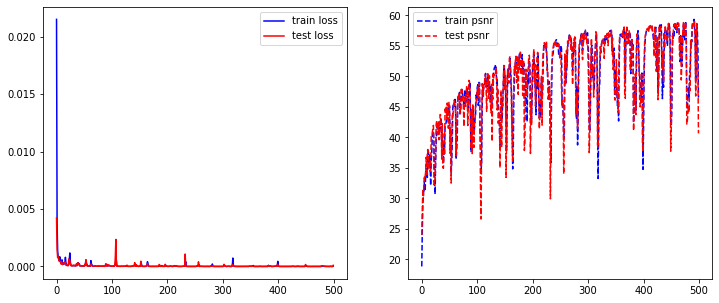

In [ ]:
#plot loss & psnr

_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

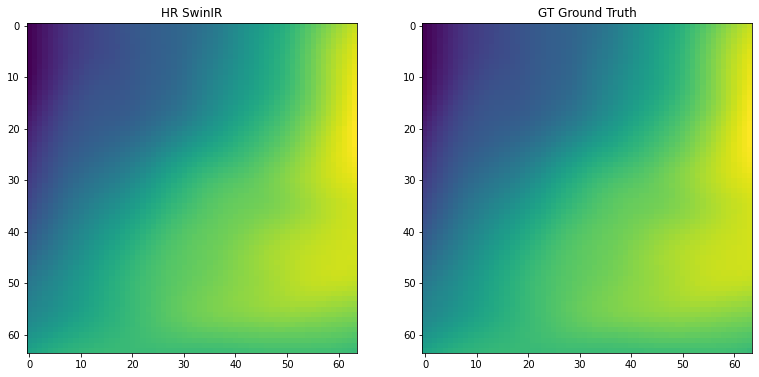

In [ ]:
#plot example
tests, targets = next(iter(testloader))

with torch.no_grad():
  GT = targets[0].squeeze()
  HR = model(tests[0][None, :].to(device).float()).squeeze()

  _, ax = plt.subplots(1,2)
  ax[0].imshow(HR.detach().cpu().numpy())
  ax[1].imshow(GT)
  ax[0].title.set_text('HR SwinIR')
  ax[1].title.set_text('GT Ground Truth')

  _.set_size_inches(13,13)
  plt.show()

In [ ]:
#Errors

errors_L1 = []
error_L2 = 0

for i, (tests, targets) in enumerate(testloader):
  for idx in range(len(tests)):

    GT = targets[idx].squeeze().detach().numpy()
    HR = model(tests[idx][None, :].to(device).float()).squeeze().detach().cpu().numpy()
    
    errors_L1.append(np.abs((HR - GT) / GT))
    error_L2 += np.sqrt(((HR - GT)**2).sum() / (GT**2).sum())

errors_L1 = np.array(errors_L1)
error_L2 /= 56

Text(0.5, 0.98, 'relative L1 error')

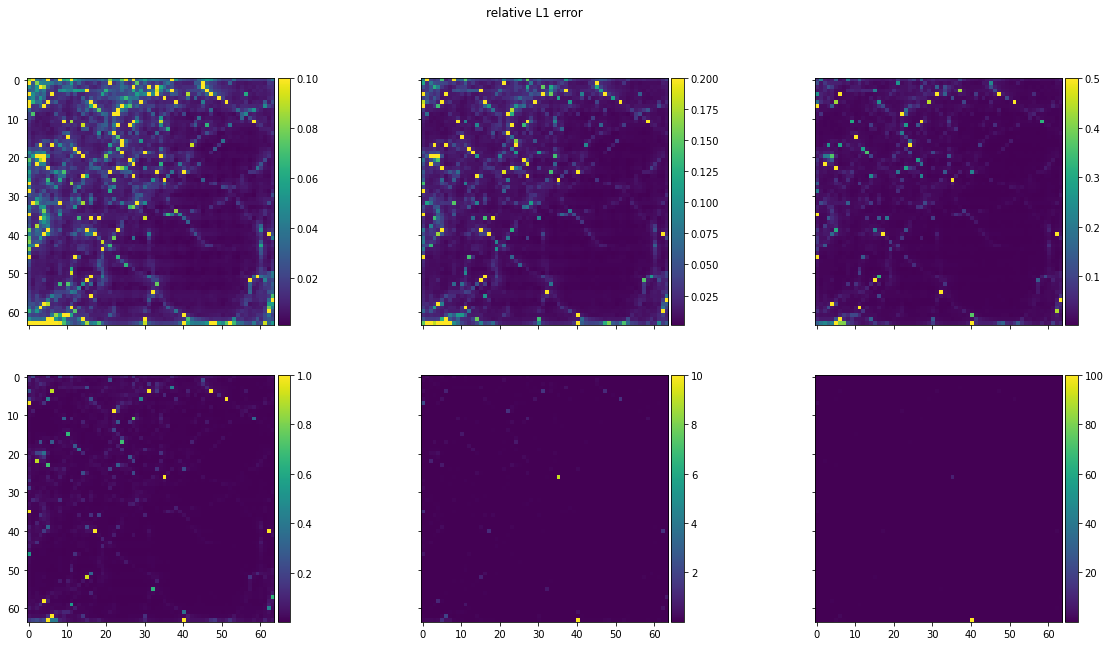

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
MAX = [0.1, 0.2, 0.5, 1, 10, 100]

k=-1
im=[]
for i in range(2):
    for j in range(3):
        k += 1
        im.append(ax[i,j].imshow(errors_L1.mean(axis=0), vmax=MAX[k]))
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im[k], cax=cax, orientation='vertical')

plt.suptitle('relative L1 error')

In [ ]:
error_L2

0.02936154888541904